# Simulated Annealing-based UPF Placement and Chaining
https://www.sciencedirect.com/science/article/pii/S1084804521002654

In [3]:
import os
import pickle
import csv
import numpy as np
import pandas as pd
import math
import time
import random
import copy
from matplotlib import pyplot as plt 

In [2]:
def import_data(dir_data, file_name):
    """THis function imports the data that it is in dir_data+file_name"""
    with open (dir_data+file_name, "rb") as fp:
        return pickle.load(fp)

### Initial Solution/State

In [91]:
# Path to initial solution
dir_data = 'path_initial_solution'  


S = import_data(dir_data, "S")                             # Number of users/sessions (i.e., PDU sessions or SFCR)
capacity_nc = import_data(dir_data, 'Dict_C_c')            # Node capacity
capacity_ct = import_data(dir_data, 'Dict_C_t')            # VNF capacity per VNF type
capacity_links = import_data(dir_data, 'Dict_Links_Capacity')       # Link capacity
M_t = import_data(dir_data,'M_t')                          # Max number of instances per type


#Importing paths data 
Edges = import_data(dir_data,"Edges")                              # dict with key nodes_id (en & ran) and value latency
Dict_Links_Capacity = import_data(dir_data,"Dict_Links_Capacity")  # dict with key nodes_id (en & ran) and value bandwidth
Paths = import_data(dir_data,"Paths")
Paths_links_mapping = import_data(dir_data,'Paths_links_mapping')  # W_p_uv


#SA parameter
NS_method = import_data(dir_data, 'NS_method')              # Method to generate neighbor solutions (NS)
MCL_method = import_data(dir_data, 'MCL_method')            # MCL method (fixed or variable)
mcl_max = import_data(dir_data, 'mcl_max')                  # Max length of the chain
mcl_min = import_data(dir_data, 'mcl_min')                  # Min length of the chain
RS_method = import_data(dir_data, 'RS_method')              # Restart method (classical or proposed one)
P_restart = import_data(dir_data, 'P_restart')              # Restart period: number of temperatures
P_stop = import_data(dir_data, 'P_stop')                    # Stop period: number of restarts
IS = import_data(dir_data, 'IS')                            # Initial solution (IS) type: 'random', proposed heuristic, etc.

In [93]:
if IS == 'random':
    # Random Heuristic as Initial solution
    dir_data_is = 'Path_initialsolution_random/'  

else:
    # Basic_Heuristic as Initial solution
    dir_data_is = 'Path_initialsolution_proposed/'   
        
# Data of the solution in a dictionary
initial_state = import_data(dir_data_is, 'solution_S'+str(S))   # S: number of SFCRs

#converting Initial_state to a dictionary
initial_solution = {}
initial_solution['ServersCap'] = copy.deepcopy(initial_state['ServersCap'][0])
initial_solution['LinksCap'] = copy.deepcopy(initial_state['LinksCap'][0])
initial_solution['OpenServers'] = copy.deepcopy(initial_state['OpenServers'][0])
initial_solution['VNFInstances'] = copy.deepcopy(initial_state['VNFInstances'][0])
initial_solution['VNFCapacity'] = copy.deepcopy(initial_state['VNFCapacity'][0])
initial_solution['NodeVNFInstances'] = copy.deepcopy(initial_state['NodeVNFInstances'][0])
initial_solution['VNFSFCAssigned'] = copy.deepcopy(initial_state['VNFSFCAssigned'][0])
initial_solution['SFCMapping'] = copy.deepcopy(initial_state['SFCMapping'][0])

session_info = import_data(dir_data, 'SessionInfo_S'+str(S))     # SFCR info: requirements, sourceBS, etc.
session_info = pd.DataFrame(session_info)

### SA Functions

In [97]:
def determine_candidates(source_vnf, Lprop_vnf):
    """This fucntion determines the candidates for the placement of a given vnf given the propagation
     delay budget.
    Inputs:
    -source_vnf: The id of the source node (the previous vnf in the branch of the current vnf)
    -Lprop_vnf. the latency budget for the propagation delay    
    Output:
    - List_c: A list with the position of the candidates
    """      
    List_c = []
    
    for kp, vp in Paths.items():   # kp, vp: path, propagation delay
        if kp[0] == source_vnf and vp <= min(Lprop_vnf):
            if kp[1] not in List_c:
                List_c.append(kp[1]) 
                
    return List_c

In [98]:
def get_cost(solution_in_cost, weight_factors, capacity_nc, capacity_ct):
    """
    It calculates cost of the solution according to their weight in the objective function.
    """
    
    # Normalization parameters
    Worst_latency = 100  # Can be set according to the max propagation delay budget
    max_upf = round(sum(capacity_nc.values())/min(capacity_ct.values()))        # max number of UPFs that can be deployed
    max_server = len(capacity_nc)           # max number of servers that can be used
    
    # Values of terms in the objective function
    num_open_servers = len(solution_in_cost['OpenServers'])
    num_upf_instances = sum([len(v) for v in solution_in_cost['VNFInstances'].values()])
    
    latency_prop = 0
    branches = 0
    for k,v in solution_in_cost['SFCMapping'].items():
        for branch in session_info[session_info['SessionId']==k]['Presence'].values[0]:
            latency_branch = sum([Paths[a]*b for a,b in zip(v['Paths'],branch)])/Worst_latency  # one way and linearizando
            latency_prop += latency_branch
            branches += 1

    # Computing deployment cost
    variable_values = [num_open_servers/max_server, num_upf_instances/max_upf, latency_prop/branches]
    cost = sum([a*b for a,b in zip(weight_factors,variable_values)])
    
    return cost

In [99]:
def verify_candidate(c, source_vnf, vnf_type, row, maped_solution):
    """
    This function verifies that none constarints is violated if a vnf is placed at this location.
     It also verifies the existence of a path with available capacity. In case of more than one path it 
     returns the shortest one.
    Outputs:
    -list_const: list with number of constraints violated. If no constraint is exceeded, then is empty
    -selectd_path: selected path for the routing. default value=none
    -VariableValues: Binary Tuple (openserver, newinstance, delay). Default values [0,0,0]
    """

    list_const = []
    selected_path = None
    VariableValues =  [0,0,0]
    
    # verifying the existence of a vnf instance of same type
    Instances_c = maped_solution['NodeVNFInstances'].get(c, {}).get(vnf_type, None)
    VNFCapFailure = False 
    
    if Instances_c != None:  #There is at least a VNf instance of the same type
        # Verify instances capacity
        VNFCapFailure = True
        for inst in Instances_c:
            if maped_solution['VNFCapacity'][vnf_type][inst] >= row['Demand'].values[0]:
                VNFCapFailure = False
                break          
    if Instances_c == None or VNFCapFailure: #There is not instances or they do not have capacity
        if maped_solution['ServersCap'][c]< capacity_ct[vnf_type]:   #the candidate does not have more capacity
            list_const.append('C1')
            if VNFCapFailure:
                list_const.append('C2')     
        else:
            # I should create a new instance of vnf_type, but before we need to verify the max num instances
            if len(maped_solution['VNFInstances'].get(vnf_type, []))+1>M_t[vnf_type]:
#                 print("Failure due to C4")
                list_const.append('C4')

    # verifying UPF constraints
    if vnf_type==1:  # It's a PSA UPF
        for v in maped_solution['SFCMapping'].get(row['SessionId'].values[0], {}).get('VNFs', {}).values():
            # Anti-affinity constraint:
            if v[0]==vnf_type and v[2]==c:   # v--> (type, instance, c)
                list_const.append('C16')
                break
            # PSA_IUPF constraint:
            elif v[0]==2 and v[2]==c:   # v--> (type, instance, c)
                list_const.append('C17')
                break           
                
    # finding the shortest path with available capacity
    pathid=[]
    pathdelay=[]
    for k,v in Paths.items():
        if k[0]==source_vnf and k[1]==c:
            pathid.append(k)
            pathdelay.append(v)
    SortedPaths = [x for _,x in sorted(zip(pathdelay, pathid))]     # sorting paths by their prop delay        
    
    #checking path capacity
    for path in SortedPaths:
        LinkCapFailure = False
        for link,v in Paths_links_mapping[path].items():
            if v==1: #verify link capacity
                if maped_solution['LinksCap'][link]<row['Bw'].values[0]:
                    LinkCapFailure = True
                    break
        if not LinkCapFailure:
            selected_path = path
            break
            
    if selected_path==None: 
        list_const.append('C3')
 
    if len(list_const)==0: # Determing the VariableValues
        if maped_solution['NodeVNFInstances'].get(c, None)== None:
            VariableValues[0] = 1
            VariableValues[1] = 1
        elif VNFCapFailure or Instances_c == None:
            VariableValues[1] = 1
        VariableValues[2] = Paths[selected_path]/100
        
    return list_const, selected_path, VariableValues

In [100]:
def release_resources(solution, session_info, selected_sessions):
    """
    Release the resources of the selected sessions by unmapping them
    """
    
    releas_solution = copy.deepcopy(solution)
    
    #release resources assigned to the selected sessions
    for s in selected_sessions: 
        session_data = session_info[session_info['SessionId']==s]

        # Release link resources
        for path in releas_solution['SFCMapping'][s]['Paths']:
            for link,v in Paths_links_mapping[path].items():
                if v==1: 
                    #update link capacity
                    releas_solution['LinksCap'][link] += session_data['Bw'].values[0]
                    
        # Release vnf resources
        for vnf_id, vnf_mapping in releas_solution['SFCMapping'][s]['VNFs'].items():
            
            vnf_type, vnf_instance, vnf_loc = vnf_mapping
            releas_solution['VNFCapacity'][vnf_type][vnf_instance] = round(releas_solution['VNFCapacity']
                                                                           [vnf_type][vnf_instance]
                                                                           +session_data['Demand'].values[0],2)
            releas_solution['VNFSFCAssigned'][vnf_type][vnf_instance] = [sfc for sfc in releas_solution
                                                                         ['VNFSFCAssigned'][vnf_type]
                                                                         [vnf_instance]  if sfc!=s]
            
            # verifying if vnf_instance is empty       
            if releas_solution['VNFCapacity'][vnf_type][vnf_instance] == capacity_ct[vnf_type]: 
                releas_solution['VNFInstances'][vnf_type] = [f for f in releas_solution['VNFInstances'][vnf_type]
                                                           if f!=vnf_instance]  
                releas_solution['NodeVNFInstances'][vnf_loc][vnf_type] = [f for f in releas_solution['NodeVNFInstances'][vnf_loc][vnf_type]
                                                                          if f!=vnf_instance]
                releas_solution['VNFCapacity'][vnf_type].pop(vnf_instance)

                #update candidate capacity
                releas_solution['ServersCap'][vnf_loc] = round(releas_solution['ServersCap'][vnf_loc]
                                                                    + capacity_ct[vnf_type],2)

                #verifying the capacity of the candidate, if it's empty we should close it
                if releas_solution['ServersCap'][vnf_loc] == capacity_nc[vnf_loc]:
                    releas_solution['OpenServers'] = [c for c in releas_solution['OpenServers'] if c !=vnf_loc]
                    releas_solution['NodeVNFInstances'].pop(vnf_loc)

        #deleting the session from sfc_mapping set
        releas_solution['SFCMapping'].pop(s)

    return releas_solution

In [101]:
def mapping_sessions(selected_sessions, mapping_solution, mode_m, weight_factors):
    """
    The mapping proedure must be able to map all the selected SFCs and also to guarantee a feasible deployment. 
    Besides the final result must be different from the initial
    mode_m: Indicate the manner in which the candidate for a vnf is selected (best_cost, random)
    """
    
    #make copy of the current placemnt state
    map_solution = copy.deepcopy(mapping_solution)
    Dict_counter_s = {}
    Dict_mode_s = {}
    for s in selected_sessions:
        Dict_mode_s[s] = mode_m
    counter_chances = 5
    flag_mapp_error = False
   
    while len(selected_sessions)!=0:
        s = random.choice(selected_sessions)
        row = session_info[session_info['SessionId']==s]
        maped_solution = copy.deepcopy(map_solution)        
        flag_mapping_error = False
        CommomVNFLoc = {}  #dict vnf_id as key and c, lprop as value
        for branch, Lprop in zip(row['Presence'].values[0], row['L_prop'].values[0] ):
            if not flag_mapping_error:
                source_vnf, Lprop_vnf = row['SourceBS'].values[0], [Lprop] # updated with placement of each VNfs

                for vnf, vnf_id, vnf_type  in zip(branch, row['VNFs'].values[0], row['Type'].values[0]):
                    if vnf==1: # it's present in the branch and we need to place it
                        if CommomVNFLoc.get(vnf_id, None)==None: # the vnf is not common or not has been mapped yet
                            Cost_vnf = 100000              # set to ahigh value
                            # Determine candidate nodes according to Lprop
                            List_c = determine_candidates(source_vnf, Lprop_vnf)
                            unfeasible_candidates = {} 
                            feasible_cadidates = {}                    
                            for c in List_c:
                                #Verify candidate
                                list_const, selected_path, variablevalues = verify_candidate(c, source_vnf, vnf_type, row,
                                                                                             maped_solution)                                

                                if len(list_const) == 0 and selected_path != None:   
                                    #Feasible candidate
                                    Cost_c = sum([a*b for a,b in zip(weight_factors, variablevalues)])  
                                    if Cost_c < Cost_vnf:
    #                                     print("%s is a better candidate with costs %s" %(c, Cost_c))
                                        Cost_vnf = Cost_c
                                        best_c = c
                                    feasible_cadidates[c] = [selected_path, variablevalues]
                                else:                                              
                                    #Unfeasible candidate
                                    unfeasible_candidates[c] = list_const    # save the unfeasibility cause

                            if len(feasible_cadidates)!=0:  
                                #Update_placememnt since there are feasible candidates
                                if Dict_mode_s[s] == 'random': # select randomly one of the feasible candidates
                                    best_c = random.choice(list(feasible_cadidates.keys()))
                                       
                                best_selectedpath = feasible_cadidates[best_c][0]
                                best_variable_values = feasible_cadidates[best_c][1]
#                                 print('best_variable_values', best_variable_values)
#                                 print('updating the vnf mapping in %s' %(best_c), best_variable_values)

                                if best_variable_values[0]==1: 
                                    # Opening of a new server   
                                    maped_solution['OpenServers'].append(best_c)

                                if best_variable_values[1] == 1: 
                                    # create a new instance of vnf_type   
                                    maped_solution['ServersCap'][best_c] = round(maped_solution['ServersCap'][best_c]-capacity_ct[vnf_type],2)
                                    current_instances = maped_solution['VNFInstances'].get(vnf_type, [])

                                    for instance in range(1,M_t[vnf_type]+1):
                                        if instance not in current_instances: break

                                    maped_solution['VNFInstances'].setdefault(vnf_type,[]).append(instance)
                                    maped_solution['VNFCapacity'].setdefault(vnf_type,{})[instance] = capacity_ct[vnf_type]
                                    maped_solution['NodeVNFInstances'].setdefault(best_c, {}).setdefault(vnf_type,[]).append(instance)
                                
                                else:  
                                    # find instance with capacity
                                    for instance in maped_solution['NodeVNFInstances'][best_c][vnf_type]:
    #                                     print('instance with capacity', instance)
                                        if maped_solution['VNFCapacity'][vnf_type][instance] >= row['Demand'].values[0]: break
                                
                                # update sets
                                maped_solution['VNFCapacity'][vnf_type][instance] = round(maped_solution['VNFCapacity'][vnf_type][instance]-row['Demand'].values[0],2)
                                maped_solution['SFCMapping'].setdefault(s, {}).setdefault('VNFs', {})[vnf_id] = (vnf_type, instance, 
                                                                                                      best_c)
                                maped_solution['SFCMapping'].setdefault(s, {}).setdefault('Paths', []).append(best_selectedpath)
                                maped_solution['VNFSFCAssigned'].setdefault(vnf_type,{}).setdefault(instance, []).append(s)

                                for link,v in Paths_links_mapping[best_selectedpath].items():
                                    if v==1: 
                                        #update link capacity
                                        maped_solution['LinksCap'][link]-= row['Bw'].values[0]             
                                source_vnf, Lprop_vnf = best_c, [Lprop_vnf[0]-Paths[best_selectedpath]]
                                
                                #Updating common vnf data
                                if row['Common'].values[0][vnf_id-1]==1:  #vnf_id is common
                                    CommomVNFLoc[vnf_id]=(best_c, Lprop_vnf)

                            else:
                                flag_mapping_error = True
                                break

                        else:
                            source_vnf, Lprop_vnf = CommomVNFLoc[vnf_id]     

        if not flag_mapping_error:                  
            # if no error during mapping procedure, we update resources: 
            map_solution = copy.deepcopy(maped_solution)
            selected_sessions = [sess for sess in selected_sessions if sess!=s]  #updating the set(removing mapped session)
        
        else:
            Dict_counter_s[s] = Dict_counter_s.get(s, 0) + 1
            if mode_m == 'best_cost' and Dict_counter_s[s]==1:
                Dict_mode_s[s] = 'random'
            if mode_m == 'random' and Dict_counter_s[s] == (counter_chances-1):
                Dict_mode_s[s] = 'best_cost'  # try with other mode_m
            if Dict_counter_s[s] >= counter_chances:
#                 print("PROBLEM: Unmapped Session %s" %(s), len(selected_sessions))
#                 print(Dict_counter_s)
                flag_mapp_error = True
                break

    return map_solution, flag_mapp_error

In [102]:
def get_neighbor(solution, session_info, weight_factors, flag_exploration):
    """
    Returns neighbors of the current state .
    """

    Set_selected_sessions = []
    Type_selected = []
    best_cost = 1000
     
    # Generating different types of neighbor solutions
    # Type 1: Change in the assignment of a subset of sfc
    number_neighbor_type1 = 5    # number of solutions of type 1
    for _ in range(0, number_neighbor_type1):
        ses = random.sample(list(session_info['SessionId']), k=1)
        if ses not in Set_selected_sessions:
            Set_selected_sessions.append(ses)
            Type_selected.append(1)
 
    if flag_exploration:
        # Generate solutions of type 2 and 3
        # Type 2: Change in the assignment of the sfcr of a randomly selected VNF
        vnf_type = random.choice(list(solution['VNFInstances'].keys()))
        vnf_instance = random.choice(solution['VNFInstances'][vnf_type])
        Set_selected_sessions.append(solution['VNFSFCAssigned'][vnf_type][vnf_instance])
        Type_selected.append(2)
        
        #Type 3: Change in the assignment of the sfcr of a randomly selected candidate server
        selected_sessions_type3 = []
        server = random.choice(solution['OpenServers'])
        for vnf_type, vnf_instanaces in solution['NodeVNFInstances'][server].items():
            for vnf_instance in vnf_instanaces: 
                selected_sessions_type3 += solution['VNFSFCAssigned'][vnf_type][vnf_instance]
        Set_selected_sessions.append(list(set(selected_sessions_type3)))
        Type_selected.append(3)

    for selected_sessions, type_s in zip(Set_selected_sessions, Type_selected):        
        released_solution = release_resources(solution, session_info, selected_sessions)
        
        if type_s == 1:
            mapped_solution, flag_mapp_error = mapping_sessions(selected_sessions, released_solution,
                                                                'best_cost', weight_factors)
#             mapped_solution, flag_mapp_error = mapping_sessions(selected_sessions, released_solution,
#                                                                 'random', weight_factors)
        else:
            flag_mapp_error = True
            try_chances = 3
            while flag_mapp_error and try_chances!=0:
                mapped_solution, flag_mapp_error = mapping_sessions(selected_sessions, released_solution,
                                                                    'best_cost', weight_factors)
                try_chances -= 1
        
        if not flag_mapp_error:
            cost = get_cost(mapped_solution, weight_factors, capacity_nc, capacity_ct)
        else:
            cost = 1000
            
        if cost < best_cost:
            best_cost = cost
            best_neighbor = copy.deepcopy(mapped_solution)

    return best_neighbor, best_cost  

In [103]:
def get_restart_solution(solution, session_info, weight_factors, changes, mode_r):
    """
    Returns restart solution.
    changes: Number of servers to be selected to unmap their assigned sessions
    mode_r: either random or best_cost
    """

    selected_sessions_type3 = []   
    servers = random.sample(list(solution['OpenServers']), k=changes)
    
    for server in servers:
        for vnf_type, vnf_instances in solution['NodeVNFInstances'][server].items():
            for vnf_instance in vnf_instances: 
                selected_sessions_type3 += solution['VNFSFCAssigned'][vnf_type][vnf_instance]
    selected_sessions2 = list(set(selected_sessions_type3))

    # Release resources
    released_solution2 = release_resources(solution, session_info, selected_sessions2)
    
    # Generate restart solution
    flag_mapp_error = True
    while flag_mapp_error:
        mapped_solution, flag_mapp_error = mapping_sessions(selected_sessions2, released_solution2,
                                                            mode_r,  weight_factors)
    cost = get_cost(mapped_solution, weight_factors, capacity_nc, capacity_ct)

    return mapped_solution, cost  

In [105]:
def update_temperature(T, alpha, mode_t):
    """
    Temperature dicreases as the process goes on. So far it includes the following modes: geometric, aritmetic, 
    statistical.
    Inputs:
    - T: current value of temp
    - alpha: the value(es) of the cooling parameters
    """

    if mode_t == 'geometric':
        T *= alpha
        return T

    if mode_t == 'aritmetic':
        T = max(T - alpha, 0)
        return T

    if  mode_t == 'estatistical':
        lamb = alpha[0]   # Pending to define
        std = alpha[1]
        T /= (1+(math.log(1+lamb)*T/(3*std)))
        return T

## Main Procedure

In [117]:
def simulated_annealing(initial_solution, NS_method, MCL_method, mcl_max, mcl_min, RS_method, P_restart, P_stop):
    """
    Peforms simulated annealing to find a better solution.
    Inputs:
        NS_method: It's a string indicating the method to be used to genertae the NS (NS_T1, NS_3T  & NS_ST)
        MCL_method: It specifies how the MCL changes or not (Fixed, Variable, Incremental). If fixed, mcl_max= mcl_min
        RS_method: It specifies if we consider or not restart-stop option and the type of restart (None, Classical, Proposed)
    """  

    # output variables
    List_cost = []    
    List_cost_best = []    
    List_temp = []
    List_restart_temp = []
    List_restard_costs = []
    List_restart_mean = []
    List_restart_std = []
    
    # annealing parameters
    initial_temp = 100
    final_temp = 0.01
    alpha = 0.9
    Num_T = (math.log(final_temp)-math.log(initial_temp))
    
    # NS_method: 
    if NS_method == 'NS_T1':
        flag_exploration = False
    else:
        flag_exploration = True
    
    # MCL_method:
    L_mkv = mcl_min        # we start with the minimum value in both incremental and variable cases. In fixed does
                           # not matter, because is mcl_max= mcl_min
    if MCL_method != 'Fixed':
        L_mkv_max = mcl_max
        L_mkv_min = mcl_min
        n = (math.log(final_temp)- math.log(initial_temp))/math.log(alpha)     # for incremental method
    
    # Restart-Stop method
    if RS_method != 'None':
        restart_time = P_restart
        restart_counter = 0
        tabu_list_restart_cost = []     # This parameter is only used for our proposed restart method
        List_restard_costs = []         # Sores the cost of the solutions generated during the restart period
        termination_criteria = P_stop
        termination_counter = 0

    # other parameters
    weight_factors = [0.4,0.4,0.2] # weight factors of the objective function
    
    start_time = time.process_time()

    # Initializing parameters and sets
    solution_current = copy.deepcopy(initial_solution)
    cost_current = get_cost(initial_solution, weight_factors, capacity_nc, capacity_ct)
    solution_best = copy.deepcopy(solution_current)
    cost_best = cost_current
    current_temp = initial_temp

    while current_temp > final_temp:
        list_cost_t = []  
        flag_best_updated = False
        flag_restart = False
        count_update = 0

        for _ in range(L_mkv):
            # get neighbor           
            solution_neighbor,cost_neighbor = get_neighbor(solution_current, session_info, 
                                                           weight_factors, flag_exploration)
            # Check if neighbor is the best so far 
            cost_delta = cost_current - cost_neighbor

            # determine if we should accept the current neighbor, if the new solution is better, accept it
            if cost_delta > 0:
                solution_current = copy.deepcopy(solution_neighbor) 
                cost_current = cost_neighbor

                # determine if the solution is the best so far
                if cost_neighbor < cost_best:
#                     print(' ------> The neighbor solution is better', cost_neighbor, current_temp)
                    solution_best, cost_best = copy.deepcopy(solution_neighbor), cost_neighbor
                    flag_best_updated = True

                    if NS_method == 'NS_ST':    
                        #if NS_ST is used we have to switch to exploit the region of the current solution using NS of type1 only                        
                        flag_exploration = False  
                        count_update +=1                    
                    
            # if the new solution is not better, accept it with a probability of e^(-cost/temp)
            else:     
                if random.uniform(0, 1) < np.exp(cost_delta / current_temp):
                    solution_current = copy.deepcopy(solution_neighbor)
                    cost_current = cost_neighbor
        
            list_cost_t.append(cost_current)       
            List_restard_costs.append(cost_neighbor)
        
        # update changes in NS if required (NS_ST with no improvement during the current temp)
        if NS_method == 'NS_ST' and not flag_best_updated:
            # This approach reduce the number exploration pprocedures with the tmp
            Prob = random.uniform(0, 1)
            if Prob < (math.log(final_temp)-math.log(current_temp))/Num_T and Prob >(count_update/L_mkv): 
                flag_exploration = True
            else:
                flag_exploration = False
            
        # verifying restart condition
        if RS_method != 'None':
            if not flag_best_updated:
                restart_counter += 1 

                if restart_counter == restart_time:
                    flag_restart = True

                    if RS_method =='Classical':          # Classical restart using always the best solution
                        solution_current, cost_current = copy.deepcopy(solution_best), cost_best
                    else:                          
                        mean = np.mean(List_restard_costs)
                        std = np.std(List_restard_costs)
                        flag_get_restart_solution = True

                        while flag_get_restart_solution:
                            changes =  random.choice([1,2])   # number of servers to use for unmapping their assigned sessions                            
                            solution_aux, cost_aux = get_restart_solution(solution_best, session_info, weight_factors, 
                                                                          changes, 'best_cost')  

                            z = (cost_aux- mean)/std     # z score                            
                            if (abs(z) > 1) and (round(cost_aux,3) not in tabu_list_restart_cost):                                
                                flag_get_restart_solution = False
                                tabu_list_restart_cost.append(round(cost_aux,3))                                
                                solution_current, cost_current = copy.deepcopy(solution_aux), cost_aux
                                List_restard_costs = [] 
                                break
                                                       
                    # determining if the restart solution is the best so far
                        if RS_method == 'Proposed' and cost_aux < cost_best:
                            solution_best = copy.deepcopy(solution_current)
                            cost_best = cost_aux

                    List_restart_temp.append(current_temp)
                    restart_counter = 0
                    termination_counter += 1
                    
                    if NS_method == 'NS_ST' :  # Apply intensification strategy after restart
                        flag_exploration = True

            else:
                List_restard_costs = []
                restart_counter = 0 # reset counter since a better solucion was found
                
            if termination_counter == termination_criteria: 
                # print(tabu_list_restart_cost)
                break
                
        # updatin MCL if we use a method different from Fixed
        if MCL_method == 'Incremental':
             L_mkv *= beta   # beta must be defined
        
        elif MCL_method == 'Variable':
            if flag_best_updated or flag_restart:
                L_mkv = L_mkv_max 
            else:
                L_mkv = L_mkv_min

        # update the temperature. There is defined a function to permorm this with different mechanisms
        current_temp *= alpha
                    
        #save results
        List_cost.append(list_cost_t)        
        List_cost_best.append(cost_best)
        List_temp.append(current_temp)
        
    T_exec = time.process_time() - start_time
    
    return T_exec, solution_best, cost_best, List_cost, List_cost_best, List_temp, List_restart_temp


In [120]:
T_exec, solution_best,cost_best, List_cost, List_cost_best,List_temp, List_restart_temp = simulated_annealing(initial_solution,
                                                                                                                 NS_method, 
                                                                                                                 MCL_method, 
                                                                                                                 mcl_max, 
                                                                                                                 mcl_min, 
                                                                                                                 RS_method, 
                                                                                                                 P_restart,
                                                                                                                 P_stop)

## Processing the Results

In [121]:
Total_upf = 0
Num_upf_type = {}

for k,v in solution_best['VNFInstances'].items():
    Total_upf += len(v)
    Num_upf_type[k] = len(v)
    
# Number of open servers
Num_open_c = len(solution_best['OpenServers'])
Open_servers_list = solution_best['OpenServers']

#Number of Unassigned sessions 
Num_unassigned_s = 0
Unassigned_s_list = []


SFCMapping = solution_best['SFCMapping']


# Latency
Latency_List = []

for index, row in session_info.iterrows():
    if row['SessionId'] in SFCMapping.keys():
        if row['Branches']==2:
            Lprop_m =[Paths[SFCMapping[row['SessionId']]['Paths'][0]]+Paths[SFCMapping[row['SessionId']]['Paths'][1]]
                      ,Paths[SFCMapping[row['SessionId']]['Paths'][0]]+Paths[SFCMapping[row['SessionId']]['Paths'][2]]]
            for branch, Lprop_b, Lprop in zip(row['Presence'], row['L_prop'], Lprop_m ):
        #         print(Lprop, branch)
                Lproc = row['Latency']-2*Lprop_b
                Latency_List.append(Lproc+2*Lprop)
        else:
            Lproc = row['Latency']-2*row['L_prop'][0] 
            Lprop = 0
            for path in SFCMapping[row['SessionId']]['Paths']:
                Lprop += Paths[path]

            Latency_List.append(Lproc+2*Lprop)


In [124]:
print('   Execution time', T_exec)
print('   Cost', cost_best)
print('   Number of UPF installed: ', Total_upf )
print('   Number of UPFs per type', Num_upf_type )
print('   Open servers list', Open_servers_list )
print('   Number of Open Servers', Num_open_c )
print('   Num_unassigned sessions', Num_unassigned_s)
print('   stop temper', List_temp[-1])

   Execution time 1131.6875
   Cost 0.4236557489184188
   Number of UPF installed:  48
   Number of UPFs per type {3: 9, 1: 31, 2: 8}
   Open servers list [13, 8, 9, 12, 5, 4]
   Number of Open Servers 6
   Num_unassigned sessions 0
   stop temper 15.009463529699921


#### Plotting the Results

Text(0, 0.5, 'Best Cost')

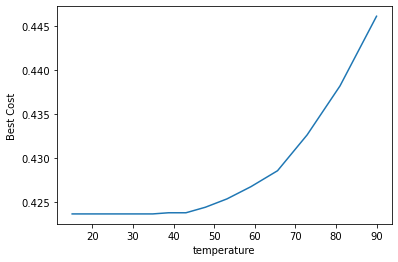

In [125]:
plt.plot(List_temp, List_cost_best)
plt.xlabel('temperature')
plt.ylabel('Best Cost')
# plt.savefig('BestCost_'+str(NS_method)+'_'+str(RS_method)+'_'+str(S)+'.pdf')

Text(0, 0.5, 'Cost')

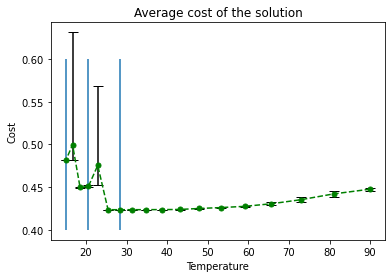

In [126]:
yerror_asymetric = [[], []]
ydata = []

for l_cost in List_cost:
    ydata.append(np.mean(l_cost))
    yerror_asymetric[0].append(np.mean(l_cost)-min(l_cost))
    yerror_asymetric[1].append(max(l_cost)-np.mean(l_cost))

plt.errorbar(List_temp, ydata, marker='o', markersize=5, color='green', linestyle='--',
            yerr=yerror_asymetric, ecolor='k',  capsize=5)
plt.vlines(x = List_restart_temp, ymin= 0.4, ymax=0.6)
plt.title('Average cost of the solution')
plt.xlabel('Temperature')
plt.ylabel('Cost')
# plt.savefig('Cost_'+str(NS_method)+'_'+str(RS_method)+'_'+str(S)+'.pdf')